# **ASSIGNMENT 1**


*   Nooran Ishtiaq
*   22i-2010
*   DS-B



In [1]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical


In [2]:
!unzip /content/DL_Assignment1_Dataset.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/DL_Assignment1_Dataset/Dataset/annotations/690_aro.npy  
  inflating: /content/DL_Assignment1_Dataset/Dataset/annotations/690_exp.npy  
  inflating: /content/DL_Assignment1_Dataset/Dataset/annotations/690_lnd.npy  
  inflating: /content/DL_Assignment1_Dataset/Dataset/annotations/690_val.npy  
  inflating: /content/DL_Assignment1_Dataset/Dataset/annotations/691_aro.npy  
  inflating: /content/DL_Assignment1_Dataset/Dataset/annotations/691_exp.npy  
  inflating: /content/DL_Assignment1_Dataset/Dataset/annotations/691_lnd.npy  
  inflating: /content/DL_Assignment1_Dataset/Dataset/annotations/691_val.npy  
  inflating: /content/DL_Assignment1_Dataset/Dataset/annotations/692_aro.npy  
  inflating: /content/DL_Assignment1_Dataset/Dataset/annotations/692_exp.npy  
  inflating: /content/DL_Assignment1_Dataset/Dataset/annotations/692_lnd.npy  
  inflating: /content/DL_Assignment1_Dataset/Dataset/annotations/692_val.npy  
 

In [3]:
images_folder = "/content/DL_Assignment1_Dataset/Dataset/images"
annotations_folder = "/content/DL_Assignment1_Dataset/Dataset/annotations"

In [4]:
class DatasetLoader:
    def __init__(self, img_folder, ann_folder, num_classes=8, augment=False):
        self.img_folder = img_folder
        self.ann_folder = ann_folder
        self.num_classes = num_classes
        self.valid_exts = [".jpg", ".jpeg", ".png", ".bmp"]
        self.augment = augment

    def _read_annotation(self, idx):
        exp = np.load(os.path.join(self.ann_folder, f"{idx}_exp.npy"))
        val = np.load(os.path.join(self.ann_folder, f"{idx}_val.npy"))
        aro = np.load(os.path.join(self.ann_folder, f"{idx}_aro.npy"))
        try:
            lnd = np.load(os.path.join(self.ann_folder, f"{idx}_lnd.npy"))
        except FileNotFoundError:
            lnd = None
        return int(exp), float(val), float(aro), lnd

    def _manual_augment(self, image):
        """Apply random augmentation using OpenCV + NumPy"""
        choice = random.choice(["flip", "rotate", "bright", "noise"])

        if choice == "flip":
            image = cv2.flip(image, 1)  # horizontal flip
        elif choice == "rotate":
            (h, w) = image.shape[:2]
            M = cv2.getRotationMatrix2D((w // 2, h // 2), angle=random.randint(-15, 15), scale=1.0)
            image = cv2.warpAffine(image, M, (w, h))
        elif choice == "bright":
            alpha = random.uniform(0.8, 1.2)   # contrast
            beta = random.randint(-30, 30)    # brightness
            image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
        elif choice == "noise":
            noise = np.random.normal(0, 20, image.shape).astype(np.uint8)
            image = cv2.add(image, noise)

        return image
    def dataframe(self):
        image_files = [
            f for f in os.listdir(self.img_folder)
            if os.path.splitext(f)[1].lower() in self.valid_exts
        ]
        indices = [os.path.splitext(f)[0] for f in image_files]

        rows = []
        for idx, fname in zip(indices, image_files):
            try:
                exp, val, aro, lnd = self._read_annotation(idx)
            except Exception as e:
                print(f"Skipping {idx}, annotation missing or error: {e}")
                continue

            img_path = os.path.join(self.img_folder, fname)
            image = cv2.imread(img_path)

            # apply augmentation if enabled
            if self.augment:
                image = self._manual_augment(image)

            rows.append({
                "idx": idx,
                "filename": img_path,
                "image": image,
                "expression": exp,
                "valence": val,
                "arousal": aro,
                "landmarks": lnd
            })

        df = pd.DataFrame(rows).sort_values("filename").reset_index(drop=True)
        return df

# Preprocessing function

In [5]:
import random
import tensorflow as tf
from tensorflow.keras import layers, models, applications
import cv2
import pandas as pd
import numpy
from sklearn.model_selection import train_test_split

# Data Preprocessing

In [6]:
IMG_SIZE = (224, 224)
def preprocess(df, num_classes=8):
    X, y_class, y_reg = [], [], []
    for _, row in df.iterrows():
        img = cv2.resize(row['image'], IMG_SIZE)
        img = img.astype("float32") / 255.0
        X.append(img)
        y_class.append(row['expression'])
        y_reg.append([row['valence'], row['arousal']])
    X = np.array(X)
    y_class = to_categorical(y_class, num_classes=num_classes)
    y_reg = np.array(y_reg, dtype="float32")
    return X, {"expression": y_class, "va": y_reg}


# Model Builder function

In [7]:
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

def build_model(input_shape=(224,224,3), num_classes=8, backbone="ResNet50"):
    if backbone == "ResNet50":
        base = keras.applications.ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
    elif backbone == "EfficientNetB0":
        base = keras.applications.EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
    elif backbone == "MobileNetV2":
        base = keras.applications.MobileNetV2(weights="imagenet", include_top=False, input_shape=input_shape)
    elif backbone == "DenseNet121":
        base = keras.applications.DenseNet121(weights="imagenet", include_top=False, input_shape=input_shape)
    elif backbone == "Xception":
        base = keras.applications.Xception(weights="imagenet", include_top=False, input_shape=input_shape)
    else:
        raise ValueError(f"Backbone {backbone} not supported")

    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dropout(0.3)(x)

    # classification head
    cls = layers.Dense(256, activation="relu")(x)
    cls = layers.Dropout(0.3)(cls)
    cls_out = layers.Dense(num_classes, activation="softmax", name="expression")(cls)

    # regression head
    reg = layers.Dense(128, activation="relu")(x)
    reg_out = layers.Dense(2, activation="tanh", name="va")(reg)

    model = models.Model(inputs=base.input, outputs=[cls_out, reg_out], name=f"multitask_{backbone}")
    return model

# Load Data

In [8]:
loader = DatasetLoader(images_folder, annotations_folder, num_classes=8, augment=True)

# Splitting Data

In [9]:
def prepare_data(loader, test_size=0.2, random_state=42):
    df = loader.dataframe()
    train_df, val_df = train_test_split(
        df, test_size=test_size, stratify=df['expression'], random_state=random_state
    )
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)

    X_train, y_train = preprocess(train_df, num_classes=loader.num_classes)
    X_val, y_val     = preprocess(val_df, num_classes=loader.num_classes)

    return X_train, y_train, X_val, y_val


In [10]:
X_train, y_train, X_val, y_val = prepare_data(loader)

# Training Using ResNet50

In [34]:
model = build_model(backbone="ResNet50", num_classes=8)
model.compile(
    optimizer="adam",
    loss={"expression": "categorical_crossentropy", "va": "mse"},
    metrics={"expression": "accuracy", "va": "mae"}
)

early_stop = EarlyStopping(monitor="val_expression_accuracy", patience=10, restore_best_weights=True,mode="max")
history = model.fit( X_train, y_train,validation_data=(X_val, y_val),epochs=50,batch_size=32,callbacks=[early_stop])

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 118s 596ms/step - expression_accuracy: 0.1361 - expression_loss: 2.3828 - loss: 2.7620 - va_loss: 0.3792 - va_mae: 0.4951 - val_expression_accuracy: 0.1250 - val_expression_loss: 2.0795 - val_loss: 2.2599 - val_va_loss: 0.1804 - val_va_mae: 0.3562
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 309ms/step - expression_accuracy: 0.1202 - expression_loss: 2.0816 - loss: 2.2959 - va_loss: 0.2142 - va_mae: 0.3783 - val_expression_accuracy: 0.1400 - val_expression_loss: 2.1030 - val_loss: 2.6396 - val_va_loss: 0.5366 - val_va_mae: 0.6014
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 306ms/step - expression_accuracy: 0.1332 - expression_loss: 2.0816 - loss: 2.2981 - va_loss: 0.2165 - va_mae: 0.3777 - val_expression_accuracy: 0.1262 - val_expression_loss: 2.0794 - val_loss: 3.1540 - val_va_loss: 1.0747 - val_va_mae: 0.9038
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 302ms/step - expression_accuracy: 0.1196 - expression_loss: 2.0876 - loss: 2.3065 - va_loss: 0

# Training Using EfficientNetB0

In [11]:
model = build_model(backbone="EfficientNetB0", num_classes=8)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss={"expression": "categorical_crossentropy", "va": "mse"},
              metrics={"expression": "accuracy", "va": "mae"})


# Early stopping
early_stop = EarlyStopping(monitor="val_expression_accuracy",  patience=10,mode="max",restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss",factor=0.5,patience=5,mode="min",verbose=1)
history = model.fit(X_train, y_train,validation_data=(X_val, y_val),epochs=50,batch_size=32,callbacks=[early_stop,reduce_lr])



16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 171s 762ms/step - expression_accuracy: 0.1529 - expression_loss: 2.1283 - loss: 2.3796 - va_loss: 0.2513 - va_mae: 0.4051 - val_expression_accuracy: 0.1250 - val_expression_loss: 2.1034 - val_loss: 2.3363 - val_va_loss: 0.2328 - val_va_mae: 0.4134 - learning_rate: 1.0000e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - expression_accuracy: 0.2575 - expression_loss: 1.9386 - loss: 2.1341 - va_loss: 0.1955 - va_mae: 0.3570 - val_expression_accuracy: 0.1112 - val_expression_loss: 2.0855 - val_loss: 2.3166 - val_va_loss: 0.2311 - val_va_mae: 0.4056 - learning_rate: 1.0000e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - expression_accuracy: 0.3232 - expression_loss: 1.7509 - loss: 1.9187 - va_loss: 0.1678 - va_mae: 0.3311 - val_expression_accuracy: 0.1150 - val_expression_loss: 2.0868 - val_loss: 2.3350 - val_va_loss: 0.2483 - val_va_mae: 0.4225 - learning_rate: 1.0000e-04
Epo

# Evaluation metrices

In [12]:
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, roc_auc_score, precision_recall_curve, auc
from sklearn.metrics import confusion_matrix
from scipy.stats import pearsonr

# ---------------- Classification Metrics ----------------

In [13]:
def classification_metrics(y_true, y_pred, y_true_oh=None, y_pred_proba=None):
    results = {}
    results['Accuracy'] = accuracy_score(y_true, y_pred)
    results['F1'] = f1_score(y_true, y_pred, average='macro')
    results['Kappa'] = cohen_kappa_score(y_true, y_pred)

    # ROC-AUC & PR-AUC need probabilities and one-hot labels
    if y_true_oh is not None and y_pred_proba is not None:
        try:
            results['AUC'] = roc_auc_score(y_true_oh, y_pred_proba, average='macro', multi_class='ovr')
        except:
            results['AUC'] = None
        try:
            pr_auc_scores = []
            for i in range(y_true_oh.shape[1]):
                prec, rec, _ = precision_recall_curve(y_true_oh[:, i], y_pred_proba[:, i])
                pr_auc_scores.append(auc(rec, prec))
            results['AUC-PR'] = np.mean(pr_auc_scores)
        except:
            results['AUC-PR'] = None

    # Krippendorff's Alpha (approximation via confusion matrix)
    cm = confusion_matrix(y_true, y_pred)
    n = np.sum(cm)
    p = np.sum(cm, axis=1) / n
    Do = 1 - np.trace(cm) / n
    De = 1 - np.sum(p**2)
    results['Alpha'] = 1 - Do / De if De != 0 else None

    return results


# ---------------- Regression Metrics ----------------

In [14]:

def regression_metrics(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    results = {}
    # RMSE
    results['RMSE'] = np.sqrt(np.mean((y_true - y_pred)**2, axis=0))
    # CORR
    corr_v, _ = pearsonr(y_true[:,0], y_pred[:,0])
    corr_a, _ = pearsonr(y_true[:,1], y_pred[:,1])
    results['CORR'] = (corr_v, corr_a)
    # SAGR
    results['SAGR'] = np.mean(np.sign(y_true) == np.sign(y_pred), axis=0)
    # CCC
    def ccc(x,y):
        x_mean, y_mean = np.mean(x), np.mean(y)
        vx, vy = np.var(x), np.var(y)
        cov = np.mean((x-x_mean)*(y-y_mean))
        return (2*cov) / (vx+vy+(x_mean-y_mean)**2+1e-8)
    results['CCC'] = (ccc(y_true[:,0], y_pred[:,0]), ccc(y_true[:,1], y_pred[:,1]))
    return results

# Run model on validation data

In [15]:
y_pred_cls_proba, y_pred_reg = model.predict(X_val)
y_true_cls_oh = y_val['expression']
y_true_reg    = y_val['va']

y_true_cls = np.argmax(y_true_cls_oh, axis=1)
y_pred_cls = np.argmax(y_pred_cls_proba, axis=1)


25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step


In [16]:
cls_results = classification_metrics(
    y_true=y_true_cls,
    y_pred=y_pred_cls,
    y_true_oh=y_true_cls_oh,
    y_pred_proba=y_pred_cls_proba
)

print("Classification metrics:")
for k, v in cls_results.items():
    print(f"{k}: {v}")


Classification metrics:
Accuracy: 0.36375
F1: 0.36350629554297625
Kappa: 0.2728571428571429
AUC: 0.7464267857142857
AUC-PR: 0.3432540514817438
Alpha: 0.2728571428571429


In [17]:
reg_results = regression_metrics(
    y_true=y_true_reg,
    y_pred=y_pred_reg
)
print("Regression metrics:")
for k, v in reg_results.items():
    print(f"{k}: {v}")

Regression metrics:
RMSE: [0.4370441 0.3691438]
CORR: (np.float32(0.44477397), np.float32(0.37724534))
SAGR: [0.715 0.74 ]
CCC: (np.float32(0.4119928), np.float32(0.33864912))


# Data Visualization

# Confusion Matrix

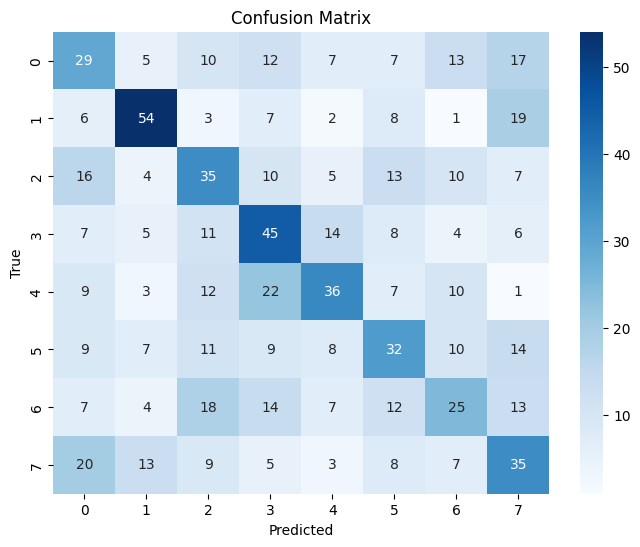

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true_cls, y_pred_cls)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# ROC Curve

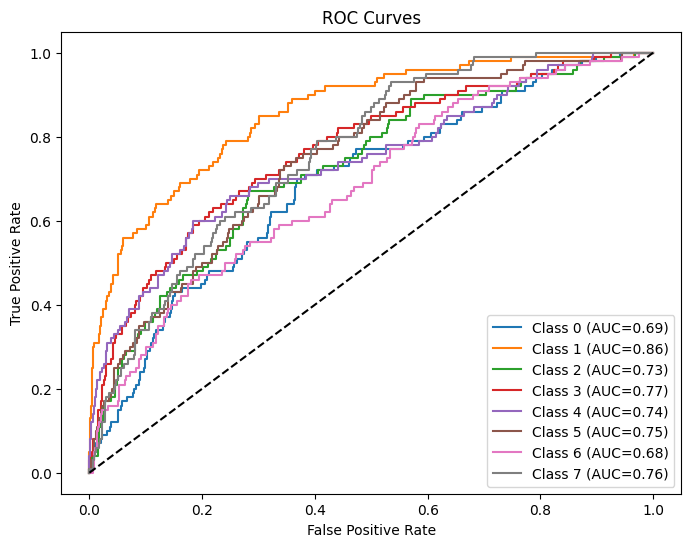

In [19]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))
for i in range(y_true_cls_oh.shape[1]):
    fpr, tpr, _ = roc_curve(y_true_cls_oh[:, i], y_pred_cls_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC={roc_auc:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


# Regression of Scatter PLot

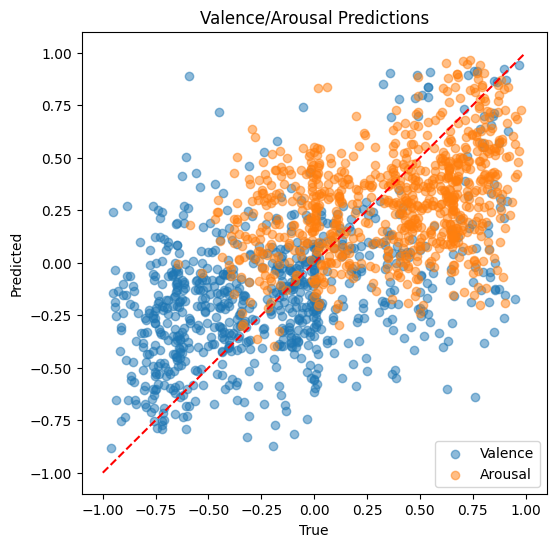

In [21]:
plt.figure(figsize=(6,6))
plt.scatter(y_true_reg[:,0], y_pred_reg[:,0], alpha=0.5, label="Valence")
plt.scatter(y_true_reg[:,1], y_pred_reg[:,1], alpha=0.5, label="Arousal")
plt.plot([-1,1], [-1,1], 'r--')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Valence/Arousal Predictions")
plt.legend()
plt.show()

# Error Distribution Plot

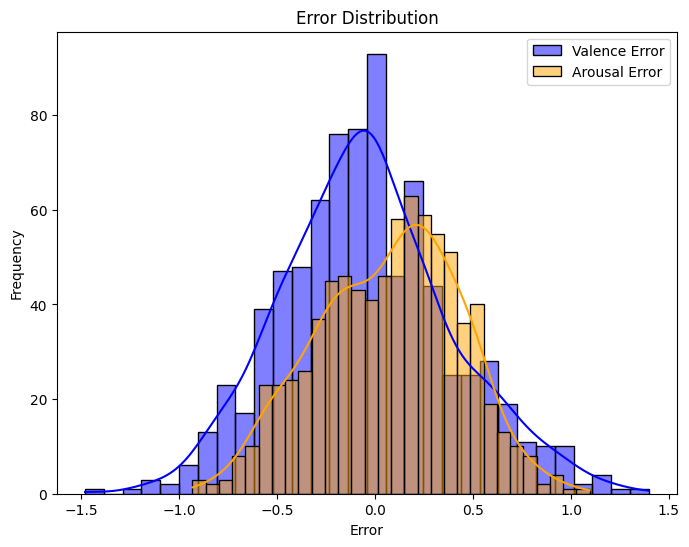

In [22]:
errors = y_true_reg - y_pred_reg

plt.figure(figsize=(8,6))
sns.histplot(errors[:,0], bins=30, kde=True, color='blue', label='Valence Error')
sns.histplot(errors[:,1], bins=30, kde=True, color='orange', label='Arousal Error')
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.title("Error Distribution")
plt.legend()
plt.show()
